[View in Colaboratory](https://colab.research.google.com/github/redcican/Machine-Learning-Basic/blob/master/Gaussian_Processes_Regression_Simple_Examples.ipynb)

A simple one-dimensional regression example computed in two different ways:
* A noise-free case
* A noisy case with known noise-level per datapoint

In both cases, the kernel's parameters are estimated using the maximum likelihood principle.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

In [0]:
def f(x):
  """The function to predict"""
  return x * np.cos(x)

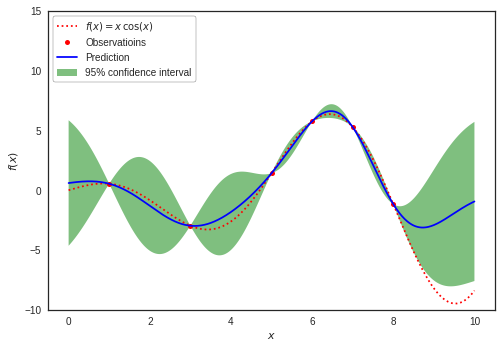

In [5]:
# First the noiseless case
X = np.atleast_2d([1., 3.,5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluation of the real function, the prediction and its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10,(1e-2,1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum likelibhhod of the parameters
gp.fit(X,y)

# Make the prediction on the meshed x-axis
y_pred, sigma = gp.predict(x, return_std=True)

# plot the function, the prediction and the 95% confidence interval based on the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\, \cos(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observatioins')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x,x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 *sigma)[::-1]]),
        alpha=.5, fc='g',ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10,15)
plt.legend(loc='upper left',frameon=True,edgecolor='black')

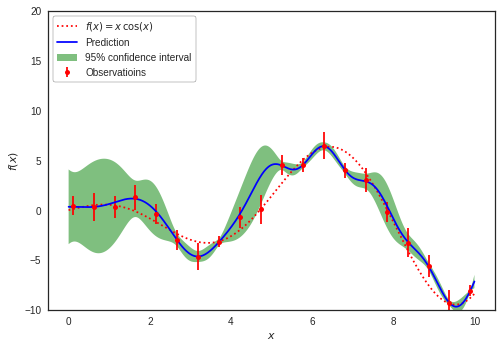

In [59]:
# The noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0*np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instanciate a GP model
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy/y)**2,
                             n_restarts_optimizer=10)

gp.fit(X,y)

y_pred, sigma = gp.predict(x, return_std=True)

# plot the function, the prediction and the 95% confidence interval based on the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\, \cos(x)$')
plt.errorbar(X.ravel(), y,dy, fmt='r.', markersize=10, label=u'Observatioins')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x,x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 *sigma)[::-1]]),
        alpha=.5, fc='g',ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10,20)
plt.legend(loc='upper left',frameon=True,edgecolor='black')

plt.show()

## Part 2

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Test data
n = 50
Xtest = np.linspace(-5,5,n).reshape(-1,1)


In [0]:
# Define the kernel functin (RBF)
def kernel(a, b, param):
  sqdist = np.sum(a**2,1).reshape(-1,1)+np.sum(b**2,1)-2*np.dot(a,b.T)
  return np.exp(-0.5 * (1/param)*sqdist)

In [0]:
param = 0.1
K_ss = kernel(Xtest, Xtest, param)

In [0]:
# Get cholesky decomposition (square root) of the covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))

# Sample 3 sets of standard normals for our test ponins,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

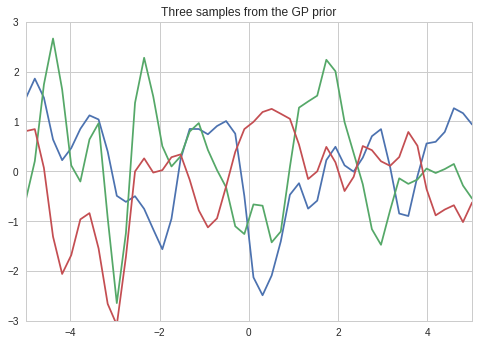

In [9]:
# plot the 3 sampled functions
plt.style.use("seaborn-whitegrid")
plt.plot(Xtest, f_prior)
plt.axis([-5,5,-3,3])
plt.title("Three samples from the GP prior")
plt.show()

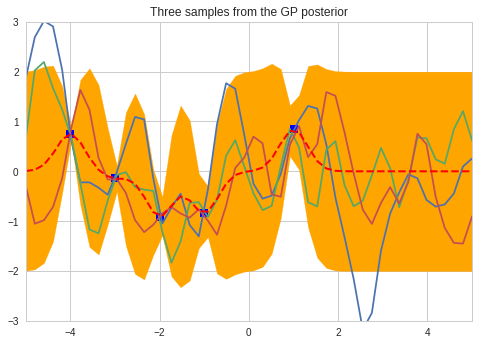

In [11]:
# Noise free training data
Xtrain = np.array([-4, -3,-2,-1,1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L,K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Comoute the standard devaitoin so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

# Draw samples from the posterior at our test points
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="orange")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5,5,-3,3])
plt.title('Three samples from the GP posterior')
plt.show()